### Evaluating Embedded Morgan Fingerprints

The code in this notebook compares Embedded Morgan Fingerprints, as described in the paper ["Embedded Morgan Fingerprints for more efficient molecular property predictions with machine learning"](https://chemrxiv.org/engage/chemrxiv/article-details/685d5791c1cb1ecda07e0680).

In [1]:
import polaris as po
import useful_rdkit_utils as uru
from embfp import convert_fp_to_embV2
import numpy as np
from tqdm.auto import tqdm
from lightgbm import LGBMRegressor
import warnings
import  pandas as pd
from sklearn.metrics import r2_score
import seaborn as sns
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt

Download the ADME-Fang dataset from [https://polarishub.io/](https://polarishub.io/)

In [2]:
ds = po.load_dataset("biogen/adme-fang-v1")
ref_df = ds.table
ref_df.rename(columns={"smiles": "SMILES"}, inplace=True)
y_list = [x for x in ref_df.columns if x.startswith("LOG")]

Output()

[2025-07-02 06:04:34] INFO     The version of Polaris that was used to create the artifact (dev) is ]8;id=599256;file:///Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/polaris/_artifact.py\_artifact.py]8;;\:]8;id=729899;file:///Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/polaris/_artifact.py#96\96]8;;\
                               different from the currently installed version of Polaris (0.13.0).                 

                      INFO     To verify the checksum, we need to recompute it. This can be slow    ]8;id=140526;file:///Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/polaris/mixins/_checksum.py\_checksum.py]8;;\:]8;id=480523;file:///Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/polaris/mixins/_checksum.py#67\67]8;;\
                               for large datasets.                                                                 

[06:04:34]  Success: Fetching dataset                                                                 ]8;id=210332;file:///Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/polaris/utils/context.py\context.py]8;;\:]8;id=847331;file:///Users/pwalters/miniforge3/envs/rdkit_2025_01/lib/python3.11/site-packages/polaris/utils/context.py#53\53]8;;\

Calcluate Morgan fingerprints and embedded Morgan fingerprints with size = [8,16,32,64]

In [3]:
def calc_descriptors(df):
    smi2fp = uru.Smi2Fp()
    df['fp'] = df.SMILES.apply(smi2fp.get_np_counts)
    for cmp in (8, 16, 32, 64):
        df[f"emb_{cmp:02d}"] = convert_fp_to_embV2(np.stack(df.fp),cmp).tolist()

Perform 5x5 cross validation.  Splits are performed using Butina clustering.

In [4]:
def cross_validate(df, y_col, desc_cols):
    smi2fp = uru.Smi2Fp()
    df['morgan'] = df.SMILES.apply(smi2fp.get_fp)
    cluster_ids = uru.taylor_butina_clustering(df.morgan.values)
    n_outer, n_inner = (5,5)
    df_list = []
    for i in tqdm(range(0,n_outer)):
        kf = uru.GroupKFoldShuffle(n_splits=n_inner, shuffle=True)    
        for j, [train_idx, test_idx] in enumerate(
                    tqdm(kf.split(df, groups=cluster_ids), total=n_inner, desc="butina", leave=False)):
            train = df.iloc[train_idx]
            test = df.iloc[test_idx]
            out_df = test[["SMILES"]].copy()
            out_df["y_val"] = test[y_col]
            out_df["y_col"] = y_col
            out_df['cycle'] = n_outer * i + j
            for desc in desc_cols:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    lgbm = LGBMRegressor(verbose=-1)
                    lgbm.fit(np.stack(train[desc]),train[y_col])
                    pred = lgbm.predict(np.stack(test[desc]))
                out_df[desc] = pred
            df_list.append(out_df)
    return df_list

Run the cross validation with all targets and all descriptors. 

In [5]:
desc_cols = ['fp','emb_08','emb_16', 'emb_32', 'emb_64']
res_dict = {}
for y in y_list:
    df = ref_df.dropna(subset=[y]).copy()
    calc_descriptors(df)
    res = cross_validate(df, y, desc_cols)
    res_dict[y] = res

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

butina:   0%|          | 0/5 [00:00<?, ?it/s]

Collect the results

In [6]:
df_list = []
for y in y_list:
    df_list.append(pd.concat(res_dict[y]))
combo_df = pd.concat(df_list)

Calculate R<sup>2</sup> statistics. 

In [7]:
r2_list = []
for k,v in combo_df.groupby(["y_col","cycle"]):
    y_col, cycle = k
    for col in desc_cols:
        r2_list.append([y_col,cycle,col,r2_score(v["y_val"],v[col])])
r2_df = pd.DataFrame(r2_list, columns=["y_col","cycle","desc","r2"])
r2_df

,y_col,cycle,desc,r2
0,LOG_HLM_CLint,0,fp,0.338888
1,LOG_HLM_CLint,0,emb_08,0.279609
2,LOG_HLM_CLint,0,emb_16,0.226525
3,LOG_HLM_CLint,0,emb_32,0.178590
4,LOG_HLM_CLint,0,emb_64,0.106359
...,...,...,...,...
745,LOG_SOLUBILITY,24,fp,0.249957
746,LOG_SOLUBILITY,24,emb_08,0.132478
747,LOG_SOLUBILITY,24,emb_16,0.184346
748,LOG_SOLUBILITY,24,emb_32,0.073331


Make the plots

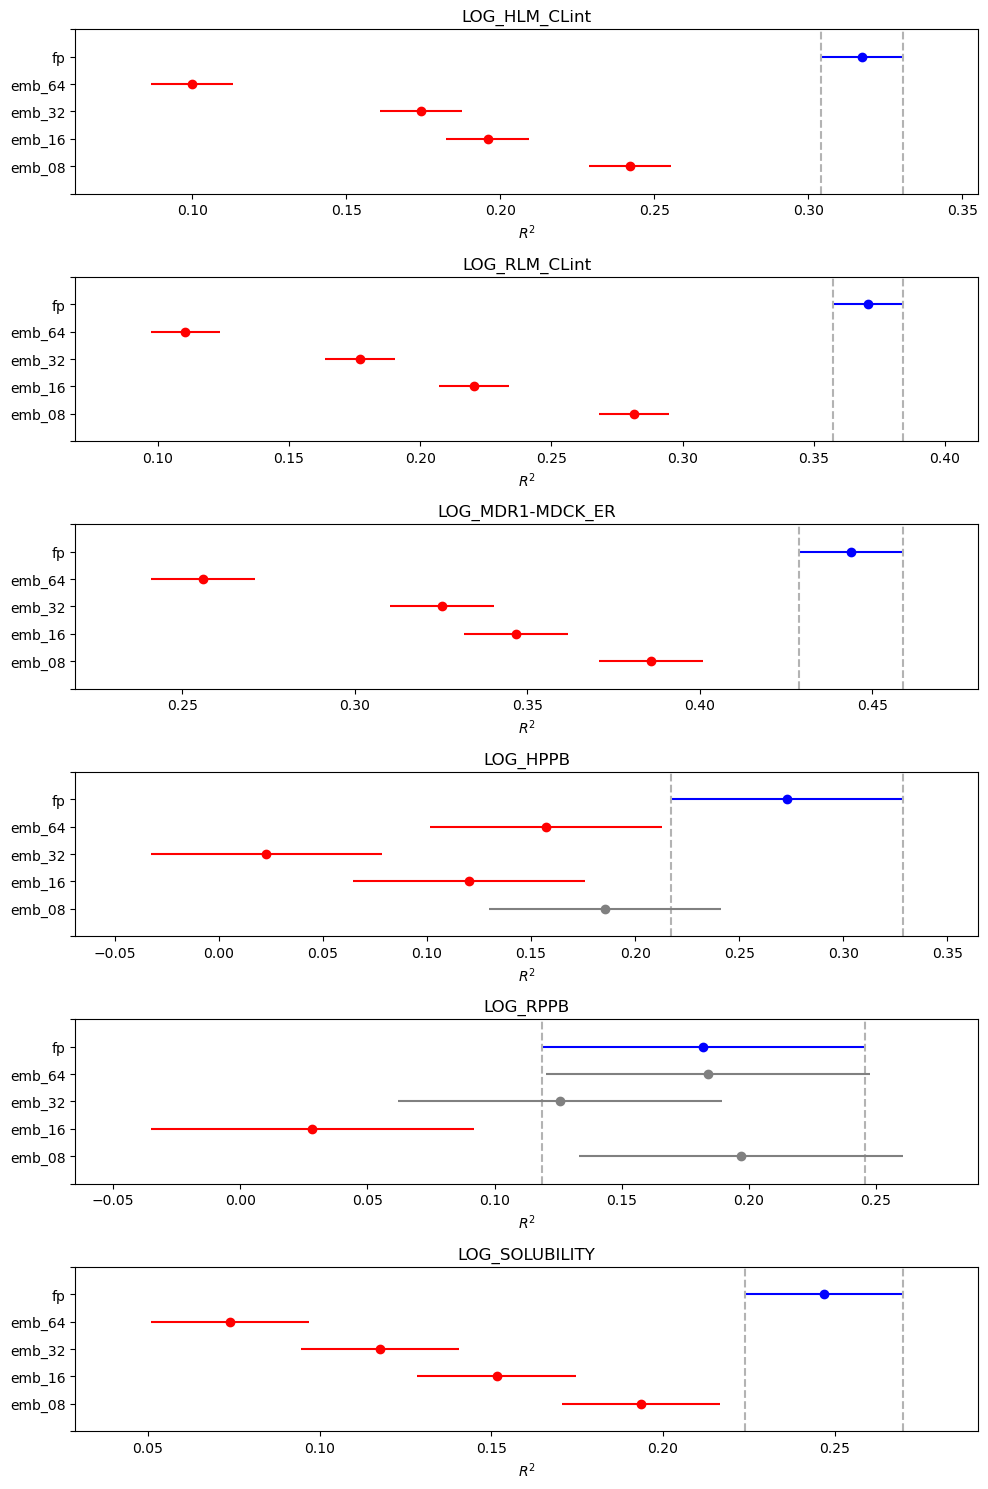

In [10]:
figure, axes = plt.subplots(len(y_list),1, figsize=(8,100))
for i,y in enumerate(y_list):
    tmp_df = r2_df.query("y_col == @y").copy()
    tmp_df.desc = pd.Categorical(tmp_df.desc,categories=desc_cols,ordered=True)
    tmp_df.sort_values("desc",inplace=True)
    tukey = pairwise_tukeyhsd(endog=tmp_df["r2"], groups=tmp_df["desc"], alpha=0.05)
    f = tukey.plot_simultaneous(comparison_name="fp",ax=axes[i],figsize=(10,15))
    axes[i].set_title(y)
    axes[i].set_xlabel("$R^2$")
plt.tight_layout()